# Flow visualization - Oslo City Bike Station Network

### Authors: Niclas Classen & Manuel Knepper
**TL;DR:** This notebook visualizes the flow of bikes between the stations of the Oslo City Bike network. The data for the bike rides is taken from https://oslobysykkel.no/en/open-data and the data for the city districts is taken from https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b. The purpose of this notebook is to analyze the flow and cycling patterns of the Oslo City Bike network.

**Reproducibility:** The repository contains the raw and preprocessed data as well as the code to reproduce the analysis. Depending on where you want to start the analysis, you can skip certain parts of the code as indicated in the notebook. 

## Part 1: Data Preprocessing

#### Data Sources:
- Oslo City Bike Data: https://oslobysykkel.no/en/open-data
- Oslo Districts Geojson: https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b

#### Data Structure
The data is stored in the following folder structure:
- `data/`: Contains all the raw and preprocessed data
- `data/monthly`: Contains the monthly raw data for the bike rides
- `data/oslo_districts.geojson`: Contains the geojson file of the Oslo districts

It is recommended to use this folder structure as it only requires minor changes in the code to run the analysis.

As result of the data preprocessing, we have the following files:
- `data/preprocessed_bike_rides.csv`: Contains the preprocessed bike rides data of all months

In [1]:
import pandas as pd
import os
from tqdm import tqdm

In [2]:
# Path to your data directory
_path = "/Users/niclasclassen/Code/Master/geospatial-ds-exam/data" #! Change this to your data directory

#### Create one file for all bike rides

In [11]:
# The following runs for 2 minutes on a 2019 MacBook Pro with 16GB RAM

dir_path = os.path.join(_path, 'monthly')

# Directory to export the combined file
export_path = os.path.join(_path)

# Get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# List to hold dataframes for each file
dataframes = []

for file in tqdm(csv_files):
    # Extract year and month from filename
    year, month = file.split('.')[0].split('_')

    # Read csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))

    # Add a new column for the month and year
    df['month'] = month
    df['year'] = year

    # Check if the DataFrame is not empty or does not contain only NaN values
    if not df.empty and not df.isna().all().all():
        # Append dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
if dataframes:
    combined_df = pd.concat(dataframes)

    # Write the combined dataframe to a new csv file in the export directory
    combined_df.to_csv(f'{export_path}/preprocessed_bike_rides.csv', index=False)

100%|██████████| 61/61 [00:33<00:00,  1.85it/s]


## Part 2: Data Analysis

In [78]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import contextily as cx
import matplotlib.pyplot as plt

### Helper functions
First we define some helper functions to load the data that we need for the analysis.

In [67]:
def create_stations_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    # Create unique dataframes for start and end stations
    start_stations = df[
        [
            "start_station_id",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()
    end_stations = df[
        [
            "end_station_id",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()

    # Rename columns for uniformity
    start_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]
    end_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]

    # Concatenate the dataframes
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs=crs_in,
    )
    gdf_stations = gdf_stations.to_crs(epsg=crs_out)

    return gdf_stations

def create_rides_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "start_station_id",
            "end_station_id",
            "started_at",
            "ended_at",
            "duration",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ]

    # Create LineString objects
    df_rides["geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides

def create_oslo_districts_gdf(
    data_path: str = "data/oslo_districts.geojson",
    crs_in: int = 32633,
    crs_out: int = 3857,
) -> gpd.GeoDataFrame:
    gdf_oslo_districts = gpd.read_file(data_path)
    # Set the correct CRS
    gdf_oslo_districts.set_crs(crs_in, inplace=True, allow_override=True)

    # Reproject the data
    gdf_oslo_districts = gdf_oslo_districts.to_crs(epsg=crs_out)

    # rename columns
    gdf_oslo_districts = gdf_oslo_districts.rename(columns={"bydelnavn": "district"})

    return gdf_oslo_districts


### 2.1 General data analysis

In [68]:
# The following runs for 5 minutes on a 2019 MacBook Pro with 16GB RAM

# Read the preprocessed data
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations = create_stations_gdf(df)
gdf_rides = create_rides_gdf(df)

# Create GeoDataFrame for Oslo districts
gdf_oslo_districts = create_oslo_districts_gdf()

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_33713/1122920903.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


#### 2.1.1 Let's have a first look at the data

##### Oslo Bike Stations

In [69]:
stations_filtered = gdf_stations.drop_duplicates(subset='station_id')

print("Stations gdf shape:", gdf_stations.shape)
print("Stations filtered gdf shape:", stations_filtered.shape)
stations_filtered.head(3)

Stations gdf shape: (15333, 8)
Stations filtered gdf shape: (286, 8)


,station_id,station_name,station_description,latitude,longitude,month,year,geometry
0,507,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,10,23,POINT (1198257.424 8381758.913)
1,607,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,10,23,POINT (1197641.308 8384785.559)
2,500,Anker Hotel,langs Storgata,59.917279,10.758155,10,23,POINT (1197592.370 8381344.042)


In [70]:
stations_filtered.explore()

##### Bike Rides

In [43]:
print("Rides gdf shape:", gdf_rides.shape)
gdf_rides.head(3)

Rides gdf shape: (7897290, 16)


,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,month,year,geometry
0,507,2339,2023-10-01 00:00:40.773000+00:00,2023-10-01 00:04:34.682000+00:00,233,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,Elgsletta,langs Nylandsveien,59.915649,10.761725,10,23,"LINESTRING (1198257.424 8381758.913, 1197989.6..."
1,607,393,2023-10-01 03:01:18.390000+00:00,2023-10-01 03:08:24.193000+00:00,425,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,Hans Nielsen Hauges plass,langs Hans Nielsen Hauges gate,59.939244,10.774319,10,23,"LINESTRING (1197641.308 8384785.559, 1199391.7..."
2,500,506,2023-10-01 03:06:04.201000+00:00,2023-10-01 03:09:44.839000+00:00,220,Anker Hotel,langs Storgata,59.917279,10.758155,Botanisk Hage vest,ved Blytts gate,59.920128,10.768875,10,23,"LINESTRING (1197592.370 8381344.042, 1198785.7..."


##### Oslo City Districts

In [46]:
print("Oslo districts gdf shape:", gdf_oslo_districts.shape)
gdf_oslo_districts.head(3)

Oslo districts gdf shape: (17, 3)


,district,bydelnr,geometry
0,Frogner,030105,"MULTIPOLYGON (((1189421.693 8375826.292, 11864..."
1,Østensjø,030113,"MULTIPOLYGON (((1206718.020 8369118.365, 12067..."
2,Søndre Nordstrand,030115,"MULTIPOLYGON (((1210120.108 8358267.151, 12100..."


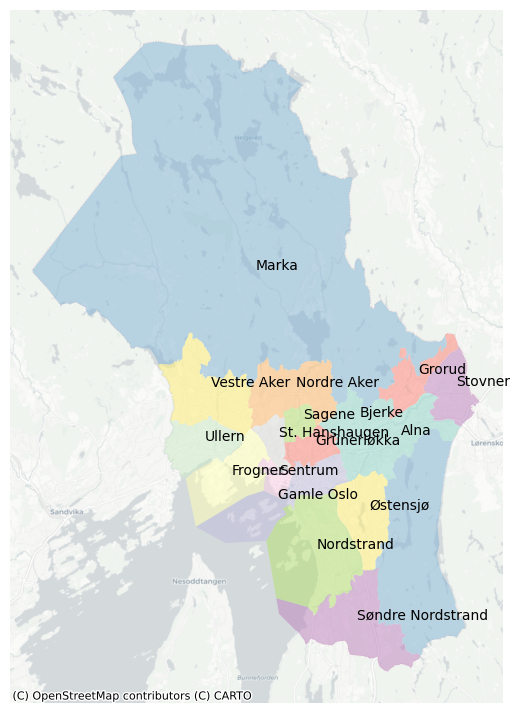

In [48]:
# Plot the unique polygons with stations, with a different color for each district
ax = gdf_oslo_districts.plot(column='district', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add a basemap
cx.add_basemap(ax, crs=gdf_oslo_districts.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(gdf_oslo_districts.geometry.centroid.x, gdf_oslo_districts.geometry.centroid.y, gdf_oslo_districts['district']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

#### 2.1.2 Change of the station network over the years

In [102]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations[gdf_stations['year'] == year]

    if year != 19:
        difference_stations_by_year[f'{year - 1}_{year}'] = set(gdf_stations_by_year[year]['station_id'].unique()) - set(gdf_stations_by_year[year - 1]['station_id'].unique())
        difference_stations_by_year[f'{year}_{year - 1}'] = set(gdf_stations_by_year[year - 1]['station_id'].unique()) - set(gdf_stations_by_year[year]['station_id'].unique())

In [101]:
# Get number of unique stations for entire dataset and for different years
for year, df in gdf_stations_by_year.items():
    number = df['station_id'].nunique()
    print(f"Number of stations in {year}: {number}")

Number of stations in 19: 254
Number of stations in 20: 255
Number of stations in 21: 262
Number of stations in 22: 269
Number of stations in 23: 273
Number of stations in 24: 268


In [108]:
# Datasets with changes in stations from year to year
stations_change_2019_2020_df = gdf_stations_by_year[20].loc[gdf_stations_by_year[20]['station_id'].isin(list(difference_stations_by_year['19_20']))]
stations_change_2020_2019_df = gdf_stations_by_year[19].loc[gdf_stations_by_year[19]['station_id'].isin(list(difference_stations_by_year['20_19']))]

stations_change_2020_2021_df = gdf_stations_by_year[21].loc[gdf_stations_by_year[21]['station_id'].isin(list(difference_stations_by_year['20_21']))]
stations_change_2021_2020_df = gdf_stations_by_year[20].loc[gdf_stations_by_year[20]['station_id'].isin(list(difference_stations_by_year['21_20']))]

stations_change_2021_2022_df = gdf_stations_by_year[22].loc[gdf_stations_by_year[22]['station_id'].isin(list(difference_stations_by_year['21_22']))]
stations_change_2022_2021_df = gdf_stations_by_year[21].loc[gdf_stations_by_year[21]['station_id'].isin(list(difference_stations_by_year['22_21']))]

stations_change_2022_2023_df = gdf_stations_by_year[23].loc[gdf_stations_by_year[23]['station_id'].isin(list(difference_stations_by_year['22_23']))]
stations_change_2023_2022_df = gdf_stations_by_year[22].loc[gdf_stations_by_year[22]['station_id'].isin(list(difference_stations_by_year['23_22']))]

stations_change_2023_2024_df = gdf_stations_by_year[24].loc[gdf_stations_by_year[24]['station_id'].isin(list(difference_stations_by_year['23_24']))]
stations_change_2024_2023_df = gdf_stations_by_year[23].loc[gdf_stations_by_year[23]['station_id'].isin(list(difference_stations_by_year['24_23']))]

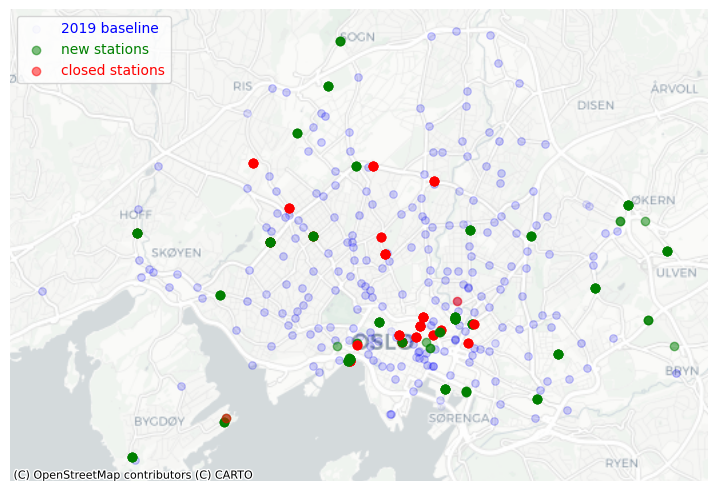

In [111]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_by_year[19].plot(alpha=0.02, ax=ax, color='blue', markersize=30, label='2019 baseline')
stations_change_2019_2020_df.plot(alpha=0.5, ax=ax, color='green')
stations_change_2020_2019_df.plot(alpha=0.5, ax=ax, color='red')
stations_change_2020_2021_df.plot(alpha=0.5, ax=ax, color='green')
stations_change_2021_2020_df.plot(alpha=0.5, ax=ax, color='red')
stations_change_2021_2022_df.plot(alpha=0.5, ax=ax, color='green')
stations_change_2022_2021_df.plot(alpha=0.5, ax=ax, color='red')
stations_change_2022_2023_df.plot(alpha=0.5, ax=ax, color='green')
stations_change_2023_2022_df.plot(alpha=0.5, ax=ax, color='red')
stations_change_2023_2024_df.plot(alpha=0.5, ax=ax, color='green', label='new stations')
stations_change_2024_2023_df.plot(alpha=0.5, ax=ax, color='red', label='closed stations')
ax.set_axis_off()
plt.legend(labelcolor= ['blue','green', 'red'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_by_year[19].crs, source=cx.providers.CartoDB.Positron)